# Modello Esponenziale {#sec-exponential-model}

**Prerequisiti**

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import arviz as az
import warnings

warnings.filterwarnings("ignore")

In [3]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "poisson-model"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")

%config InlineBackend.figure_format = "retina"

## Introduzione 

Nel contesto dell'inferenza bayesiana, il caso coniugato Gamma-Esponenziale rappresenta un potente strumento per modellare fenomeni che seguono una distribuzione esponenziale. La distribuzione esponenziale è spesso utilizzata per modellare il tempo tra eventi successivi in un processo che avviene a un tasso costante, come il tempo di attesa tra gli arrivi in una coda o la durata di certi eventi psicologici.

Ad esempio, in psicologia, possiamo utilizzare la distribuzione esponenziale per modellare la durata degli episodi di ansia o il tempo trascorso prima che un individuo manifesti un certo comportamento in risposta a uno stimolo. Supponiamo di osservare i tempi in cui diversi pazienti sperimentano episodi di disagio psicologico dopo un evento stressante. Questi tempi possono essere modellati utilizzando una distribuzione esponenziale, in cui il parametro $\lambda$ rappresenta il tasso con cui si verifica il disagio.

La verosimiglianza esponenziale per un campione di osservazioni indipendenti $y_1, y_2, \dots, y_n$, che rappresentano, ad esempio, i tempi di attesa fino a un episodio di disagio psicologico, è data da:

$$
f(y \mid \lambda) = \lambda^n e^{-\lambda \sum_{i=1}^{n} y_i}.
$$

In questo modello, $\lambda$ è il parametro che controlla il tasso medio di occorrenza degli eventi (ad esempio, episodi di disagio). Poiché spesso non conosciamo il valore di $\lambda$ a priori, possiamo utilizzare un approccio bayesiano per stimare $\lambda$, assumendo una distribuzione a priori su $\lambda$. Una scelta comune per la distribuzione a priori in questo contesto è la distribuzione Gamma, che è coniugata rispetto alla distribuzione esponenziale.

Quando si assume una distribuzione Gamma come prior su $\lambda$, la distribuzione a posteriori di $\lambda$, dopo aver osservato i dati, sarà anch'essa una distribuzione Gamma con parametri aggiornati. Questo aggiornamento incorpora le informazioni provenienti dai dati osservati, fornendo una stima più precisa del tasso di occorrenza degli eventi psicologici osservati. 

Ad esempio, dopo aver osservato i tempi di manifestazione del disagio psicologico in un gruppo di pazienti, possiamo aggiornare la nostra credenza su $\lambda$ e successivamente fare previsioni sui tempi futuri di occorrenza o valutare la probabilità di eventi specifici, come il verificarsi di un episodio severo di disagio psicologico.

## Distribuzione Esponenziale

La funzione di verosimiglianza per un campione di $n$ osservazioni indipendenti $X_1, X_2, \dots, X_n$ che seguono una distribuzione esponenziale con parametro $\lambda$ (dove $\lambda > 0$) è data dal prodotto delle densità di probabilità delle osservazioni.

La funzione di densità di probabilità (pdf) di una distribuzione esponenziale è:

$$
f(x \mid \lambda) = \lambda e^{-\lambda x}, \quad x \geq 0.
$$

Supponiamo di avere un campione di $n$ osservazioni indipendenti $X_1, X_2, \dots, X_n$. La funzione di verosimiglianza $L(\lambda)$ per questo campione è il prodotto delle pdf per tutte le osservazioni:

$$
L(\lambda \mid X_1, X_2, \dots, X_n) = \prod_{i=1}^{n} f(X_i \mid \lambda) = \prod_{i=1}^{n} \lambda e^{-\lambda X_i}.
$$

Sviluppando il prodotto, otteniamo:

$$
L(\lambda \mid X_1, X_2, \dots, X_n) = \lambda^n e^{-\lambda \sum_{i=1}^{n} X_i}.
$$

Questa è la funzione di verosimiglianza per il parametro $\lambda$ dato il campione $X_1, X_2, \dots, X_n$.

Per ottenere il logaritmo della funzione di verosimiglianza, che spesso è più facile da manipolare, calcoliamo:

$$
\log L(\lambda \mid X_1, X_2, \dots, X_n) = n \log \lambda - \lambda \sum_{i=1}^{n} X_i.
$$

## Metodo Basato su Griglia

Supponiamo di avere ossservato il seguente campione di dati.

In [55]:
# Imposta il seed per rendere i risultati riproducibili
np.random.seed(42)

# Parametro lambda per la distribuzione esponenziale
mean = 3.0
lambda_param = 1 / mean

# Numero di osservazioni nel campione
n = 15 

# Generazione del campione casuale

y = np.random.exponential(scale=mean, size=n).round()
print(y)

[ 1.  9.  4.  3.  1.  1.  0.  6.  3.  4.  0. 11.  5.  1.  1.]


Immaginiamo che questi dati corrispondano al punteggio totale della scala psicologica di Kessler (K6) -- si veda il @sec-cont-rv-distr.

Per questi dati, imponiamo una distribuzione Gamma quale distribuzione a priori per il parametro $\lambda$ della distribuzione di Poisson.

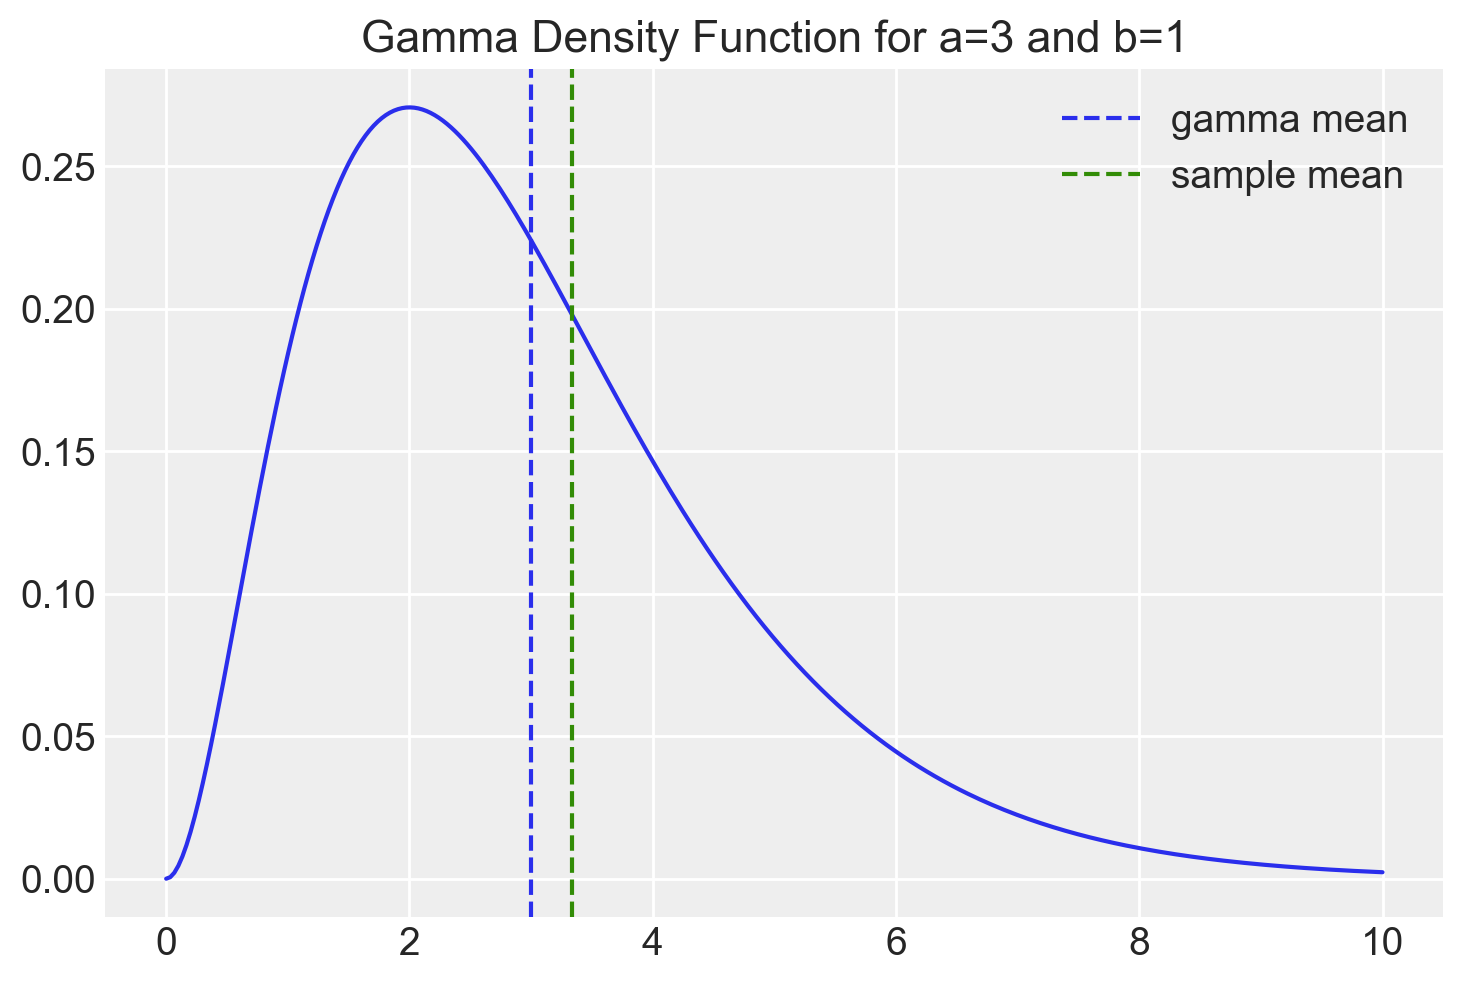

In [56]:
alpha_prior = 3
beta_prior = 1

x = np.linspace(start=0, stop=10, num=300)

plt.plot(x, stats.gamma.pdf(x, a=alpha_prior, scale=1 / beta_prior))
plt.axvline(x=alpha_prior / beta_prior, linestyle="--", label="gamma mean")
plt.axvline(x=y.mean(), linestyle="--", color="C2", label="sample mean")
plt.legend()
plt.title(f"Gamma Density Function for a={3} and b={1}")
plt.show()

Poniamoci l'obiettivo di usare il metodo basato su griglia per derivare la distribuzione a posteriori per il parametro $\lambda$ della distribuzione esponenziale. Iniziamo con la creazione della griglia per $\lambda$ nell'intervallo [0.01, 10].

In [57]:
# Evita zero per evitare divisione per zero
lambda_grid = np.linspace(0.01, 10, 1000)

Calcoliamo la distribuzione a priori.

In [58]:
prior = stats.gamma.pdf(lambda_grid, a=alpha_prior, scale=1 / beta_prior)

Calcoliamo la verosimiglianza per ciascun valore di lambda.

In [59]:
likelihood = np.ones_like(lambda_grid)
for yi in y:
    likelihood *= stats.expon.pdf(yi, scale=1/lambda_grid)

Calcoliamo la distribuzione a posteriori non normalizzata.

In [60]:
posterior_unnormalized = likelihood * prior

Normalizziamo la distribuzione a posteriori.

In [61]:
posterior = posterior_unnormalized / np.sum(
    posterior_unnormalized * (lambda_grid[1] - lambda_grid[0])
)

Visualizzazione dei risultati.

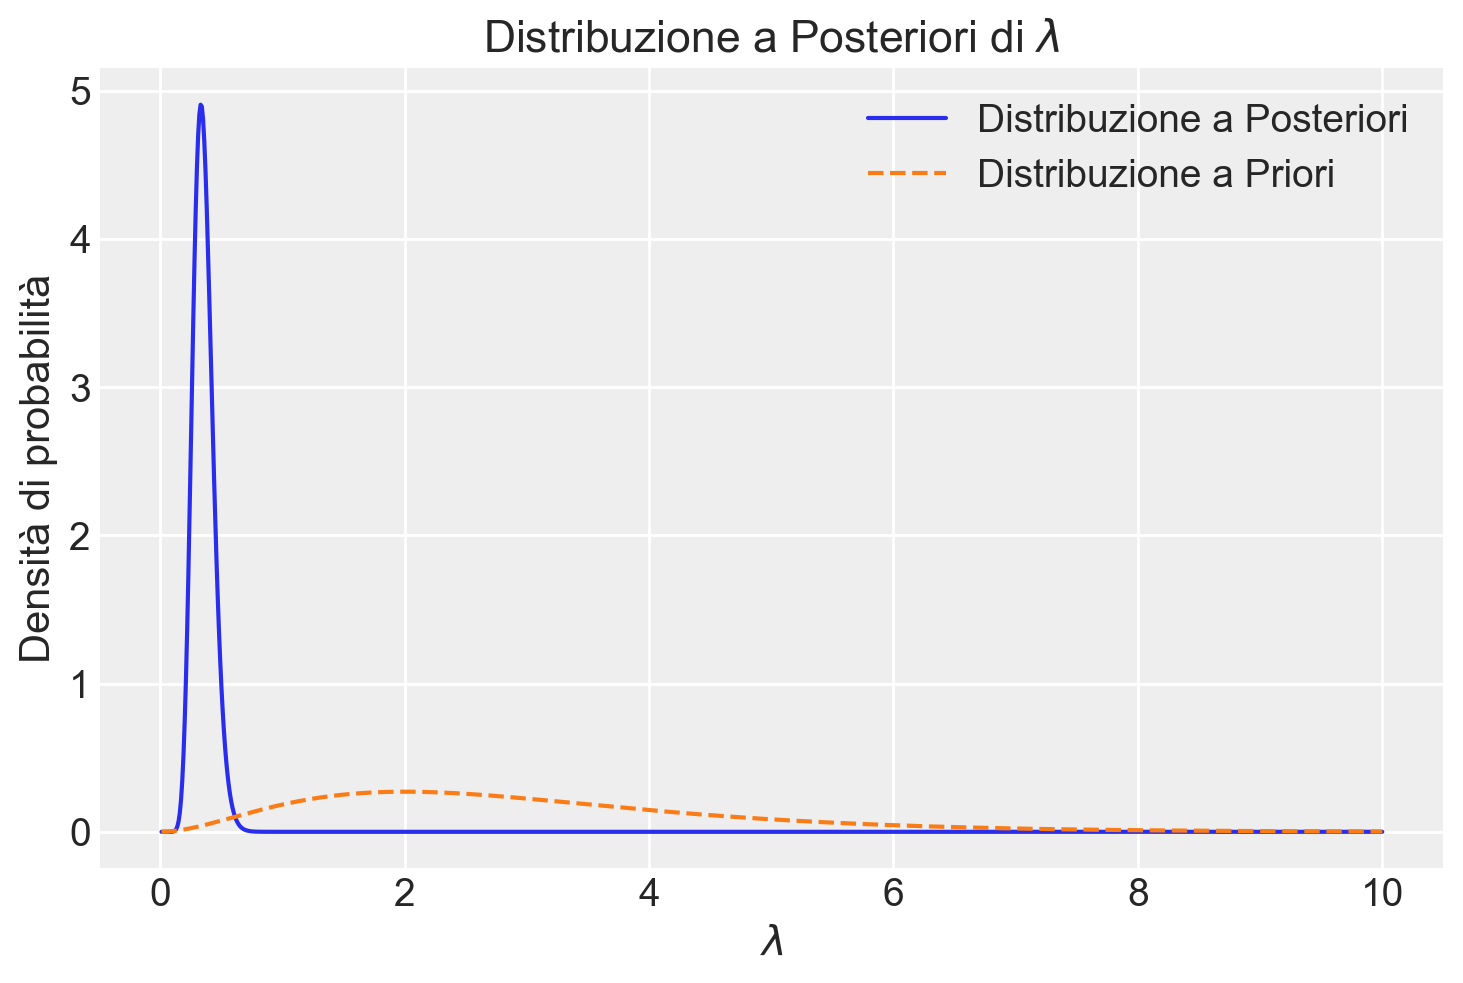

In [62]:
plt.plot(lambda_grid, posterior, label="Distribuzione a Posteriori")
plt.plot(lambda_grid, prior, "--", label="Distribuzione a Priori")
plt.xlabel(r"$\lambda$")
plt.ylabel("Densità di probabilità")
plt.legend()
plt.title("Distribuzione a Posteriori di $\lambda$")
plt.show()

## Modello Coniugato Gamma-Esponenziale

Quando utilizziamo una distribuzione $\text{Gamma}(\alpha, \beta)$ come [distribuzione coniugata a priori](https://en.wikipedia.org/wiki/Conjugate_prior), la distribuzione a posteriori risulta anch'essa essere una distribuzione Gamma, con parametri aggiornati $\alpha + n$ e $\beta + \sum_{i=1}^{n} x_{i}$.

In altre parole, se il parametro $\lambda$ della distribuzione esponenziale segue una distribuzione a priori Gamma con parametri $\alpha$ e $\beta$, allora, dopo aver osservato un campione di $n$ osservazioni $x_1, x_2, \dots, x_n$, la distribuzione a posteriori di $\lambda$ sarà ancora una distribuzione Gamma, ma con i parametri aggiornati:

$$
\lambda \mid x \sim \text{Gamma}(\alpha + n, \beta + \sum_{i=1}^{n} x_{i}).
$$

Questo aggiornamento dei parametri è una conseguenza della proprietà coniugata della distribuzione Gamma rispetto alla distribuzione esponenziale.

### Dimostrazione del Modello Coniugato Gamma-Esponenziale

Per dimostrare questo risultato, partiamo dal teorema di Bayes:

$$
f(\lambda \mid x) \propto f(x \mid \lambda) \cdot f(\lambda),
$$

dove $f(\lambda \mid x)$ è la distribuzione a posteriori di $\lambda$ dato il campione $x$, $f(x \mid \lambda)$ è la verosimiglianza basata sul campione $x$, e $f(\lambda)$ è la distribuzione a priori di $\lambda$.

La funzione di verosimiglianza per un campione di $n$ osservazioni indipendenti $x_1, x_2, \dots, x_n$, che seguono una distribuzione esponenziale con parametro $\lambda$, è data da:

$$
f(x \mid \lambda) = \prod_{i=1}^{n} \lambda e^{-\lambda x_i} = \lambda^n e^{-\lambda \sum_{i=1}^{n} x_i}.
$$

Supponiamo che il parametro $\lambda$ segua una distribuzione a priori Gamma con parametri $\alpha$ e $\beta$:

$$
f(\lambda) = \frac{\beta^\alpha}{\Gamma(\alpha)} \lambda^{\alpha - 1} e^{-\beta \lambda}.
$$

Moltiplicando la verosimiglianza per la distribuzione a priori, otteniamo la distribuzione a posteriori:

$$
f(\lambda \mid x) \propto \lambda^n e^{-\lambda \sum_{i=1}^{n} x_i} \cdot \lambda^{\alpha - 1} e^{-\beta \lambda}.
$$

Semplificando, si ottiene:

$$
f(\lambda \mid x) \propto \lambda^{n + \alpha - 1} e^{-\lambda \left(\beta + \sum_{i=1}^{n} x_i\right)}.
$$

Questa espressione corrisponde alla forma di una distribuzione Gamma con parametri aggiornati:

- parametro della forma (alpha): $\alpha_{\text{post}} = \alpha + n$;
- parametro della scala (beta): $\beta_{\text{post}} = \beta + \sum_{i=1}^{n} x_i$.

Quindi, la distribuzione a posteriori di $\lambda$ dato il campione $x$ segue una distribuzione Gamma con parametri aggiornati:

$$
\lambda \mid x \sim \text{Gamma}(\alpha + n, \beta + \sum_{i=1}^{n} x_i).
$$

Questa derivazione mostra come l'informazione contenuta nei dati osservati venga incorporata nei parametri della distribuzione a posteriori, mantenendo la forma della distribuzione a priori grazie alla proprietà coniugata.

### Applicazioni

Per il caso dell'esempio in discussione, 

- il numero di osservazioni nel campione $n$ è 15;
- la somma delle osservazioni del campione è:

$$
\sum_{i=1}^{n} y_i = 1 + 9 + 4 + 3 + 1 + 1 + 0 + 6 + 3 + 4 + 0 + 11 + 5 + 1 + 1 = 50.
$$

I parametri aggiornati della distribuzione a posteriori sono:

$$
\alpha_{\text{post}} = 3 + 15 = 18.
$$

$$
\beta_{\text{post}} = 1 + 50 = 51.
$$

Utilizzando i parametri aggiornati, rappresentiamo graficamente la distribuzione a posteriori.

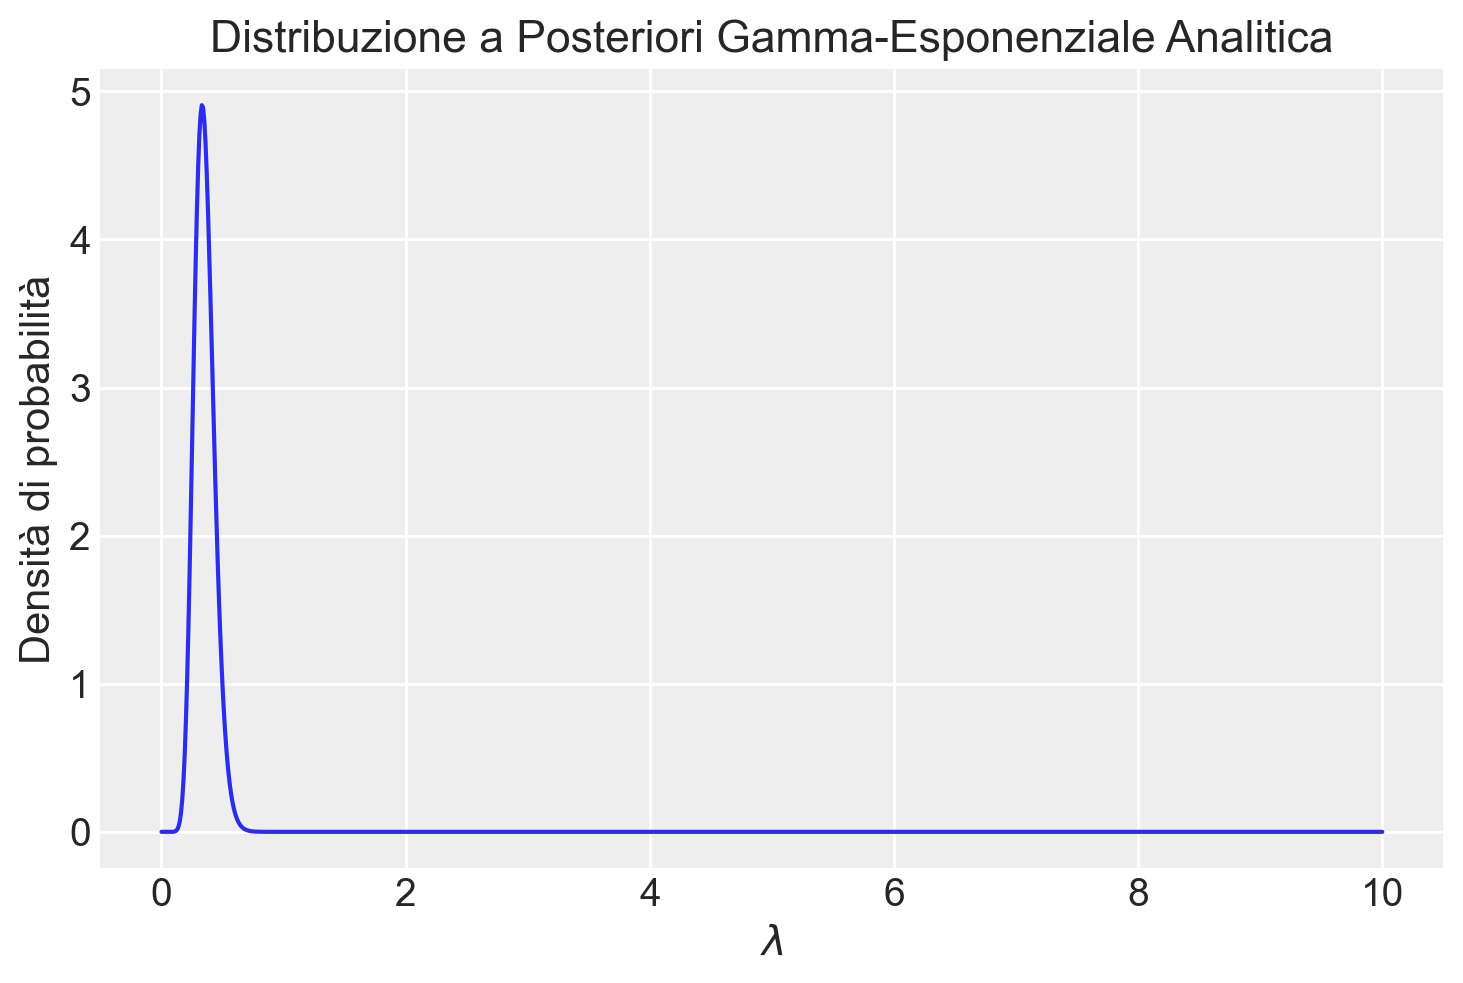

In [63]:
# Aggiornamento dei parametri per la distribuzione a posteriori
alpha_post = alpha_prior + len(y)
beta_post = beta_prior + np.sum(y)

# Griglia per il parametro lambda
lambda_grid = np.linspace(0, 10, 1000)

# Calcolo della distribuzione a posteriori analitica sulla griglia
posterior_analytic = stats.gamma.pdf(lambda_grid, a=alpha_post, scale=1 / beta_post)

# Plot della distribuzione a posteriori analitica
plt.plot(lambda_grid, posterior_analytic)
plt.title("Distribuzione a Posteriori Gamma-Esponenziale Analitica")
plt.xlabel("$\lambda$")
plt.ylabel("Densità di probabilità")
plt.show()

Questo grafico visualizza la distribuzione a posteriori analitica per il parametro $\lambda$ del modello Poisson, usando una distribuzione a priori Gamma e i dati osservati. La distribuzione a posteriori è calcolata come una Gamma aggiornata con i parametri $\alpha_{\text{post}}$ e $\beta_{\text{post}}$, rappresentando la nostra conoscenza aggiornata dopo aver visto i dati. Il risultato replica quello ottenuto mediante simulazione numerica.

Possiamo ora rispondere a domande riguardanti la probabilità che una nuova osservazione $y$ assuma determinati valori. Nel caso dell'esempio, ad esempio ci possiamo chiedere quale sia la probabilità degli eventi $y > 5$ (disagio psicologico lieve) o $y > 13$ (disagio psicologico severo). Utilizzando la distribuzione a posteriori di $\lambda$, possiamo procedere calcolando le probabilità richieste utilizzando simulazioni Monte Carlo.

Per il caso della probabilità che $y \geq 5$, 

1. Generiamo un campione di valori di $\lambda$ dalla distribuzione a posteriori $\lambda \sim \text{Gamma}(18, 51)$.
2. Generiamo un campione di valori di $y$ per ciascun $\lambda$ dalla distribuzione esponenziale $y \sim \text{Expon}(\lambda)$.
3. Calcoliamo la proporzione di valori di $y$ che sono maggiori o uguali a 5.

In [64]:
# Parametri della distribuzione a posteriori
alpha_post = 18
beta_post = 51

# Numero di simulazioni
n_sim = 10000

# Generazione di un campione di lambda dalla distribuzione a posteriori
lambda_samples = stats.gamma.rvs(a=alpha_post, scale=1 / beta_post, size=n_sim)

# Generazione di un campione di y dalla distribuzione esponenziale per ciascun lambda
y_samples = stats.expon.rvs(scale=1 / lambda_samples, size=n_sim)

# Calcolo della probabilità che y >= 5
prob_y_ge_5 = np.mean(y_samples >= 5)
print(f"Probabilità che y >= 5: {prob_y_ge_5:.4f}")

# Calcolo della probabilità che y > 13
prob_y_gt_13 = np.mean(y_samples > 13)
print(f"Probabilità che y > 13: {prob_y_gt_13:.4f}")

Probabilità che y >= 5: 0.1777
Probabilità che y > 13: 0.0164


- Probabilità che $y \geq 5$: Questo valore rappresenta la probabilità che un nuovo individuo abbia un disagio psicologico almeno moderato (definito come $y \geq 5$).
- Probabilità che $y > 13$: Questo valore rappresenta la probabilità che un nuovo individuo abbia un disagio psicologico severo (definito come $y > 13$).

## Informazioni sull'Ambiente di Sviluppo

In [22]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Sun Jun 02 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.24.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
pymc      : 5.15.0
scipy     : 1.13.0
arviz     : 0.18.0
matplotlib: 3.8.4
pandas    : 2.2.2

Watermark: 2.4.3

